# Store Sales - Time Series Forecasting

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_log_error
import lightgbm as lgb
from lightgbm.callback import early_stopping
import optuna
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import lag_plot

In [2]:
data_path = Path('data')
df_train = pd.read_csv(data_path/'train.csv', parse_dates=['date'])
df_test = pd.read_csv(data_path/'test.csv', parse_dates=['date'])
df_holidays_events = pd.read_csv(data_path/'holidays_events.csv', parse_dates=['date'])
df_oil = pd.read_csv(data_path/'oil.csv', parse_dates=['date'])
df_stores = pd.read_csv(data_path/'stores.csv')
df_transactions = pd.read_csv(data_path/'transactions.csv', parse_dates=['date'])

## Análise Exploratória dos Dados

### Sales

- Visão geral dos dados de treinamento.

In [3]:
df_train_eda = df_train.copy()
df_train_eda.head(5)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


- Vemos que não temos dados faltando.

In [8]:
df_train_eda.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           3000888 non-null  int64         
 1   date         3000888 non-null  datetime64[ns]
 2   store_nbr    3000888 non-null  int64         
 3   family       3000888 non-null  object        
 4   sales        3000888 non-null  float64       
 5   onpromotion  3000888 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [30]:
number_of_stores = len(df_train_eda['store_nbr'].unique())
number_of_families = len(df_train_eda['family'].unique())
number_of_months = (len(df_train_eda['date'].dt.year.unique()) - 1) * 12 + len(df_train_eda[df_train_eda['date'].dt.year == 2017]['date'].dt.month.unique())

pd.DataFrame({'Lojas': [number_of_stores], 'Tipos de Produtos': [number_of_families], 'Período': ['2013-2017'],'Meses': [number_of_months]})

,Lojas,Tipos de Produtos,Período,Meses
0,54,33,2013-2017,56


- Podemos ver que todas as lojas e famílias de produtos aparecem a mesma quantidade de vezes.

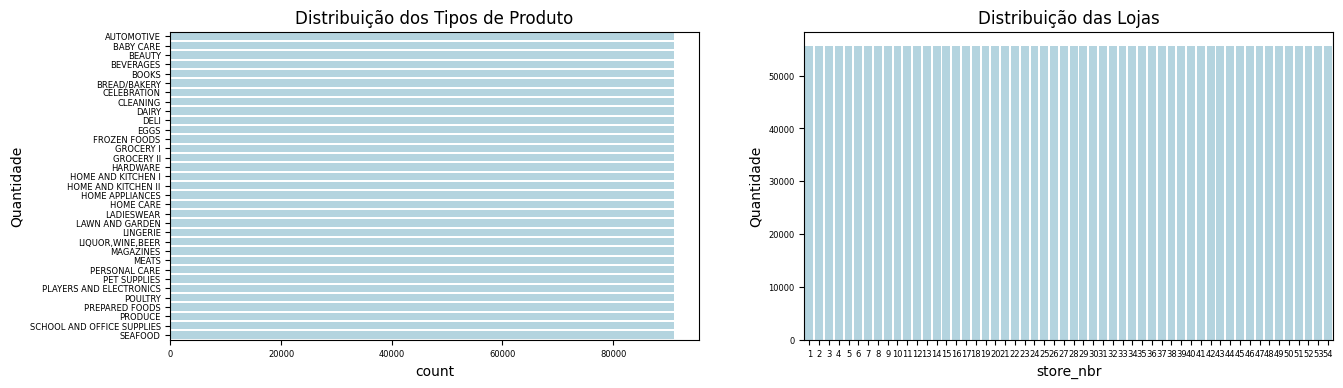

In [19]:
fig, axes = plt.subplots(1,2 , figsize=(15, 4))

sns.countplot(x=df_train_eda['store_nbr'], ax=axes[1], color='lightblue')
axes[1].set_ylabel('Quantidade')
axes[1].set_title('Distribuição das Lojas')
axes[1].tick_params(axis='x', labelsize=6)
axes[1].tick_params(axis='y', labelsize=6)

sns.countplot(y=df_train_eda['family'], ax=axes[0], color='lightblue')
axes[0].set_ylabel('Quantidade')
axes[0].set_title('Distribuição dos Tipos de Produto')
axes[0].tick_params(axis='x', labelsize=6)
axes[0].tick_params(axis='y', labelsize=6)

plt.show()

- Vemos que as vendas estão aumentando ao longo dos anos.
- Podemos perceber também que no final de cada ano a média de transações aumenta consideravelmente.

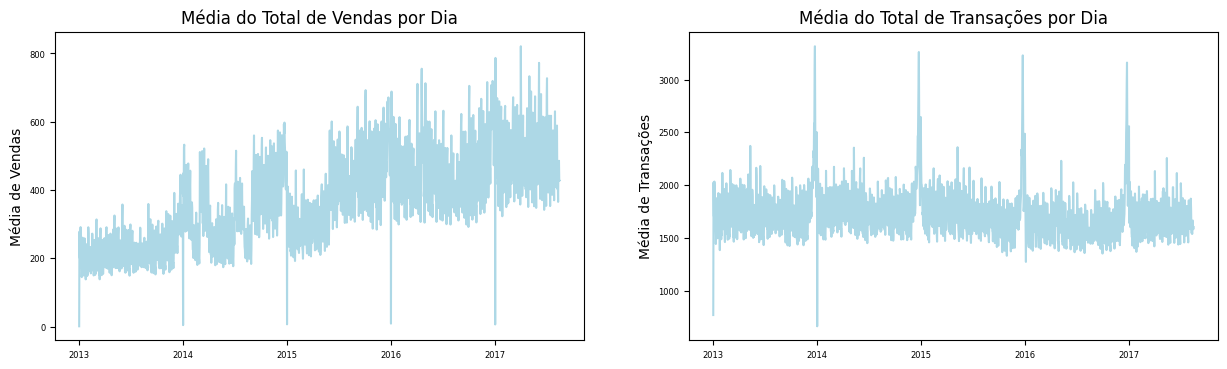

In [50]:
sales = df_train_eda.set_index("date").resample("D").sales.mean().reset_index()
transactions = df_transactions.set_index("date").resample("D").transactions.mean().reset_index()

fig, axes = plt.subplots(1,2 , figsize=(15, 4))

sns.lineplot(x=sales['date'], y=sales['sales'], ax=axes[0], color='lightblue')
axes[0].set_title('Média do Total de Vendas por Dia')
axes[0].set_ylabel('Média de Vendas')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', labelsize=6)
axes[0].tick_params(axis='y', labelsize=6)

sns.lineplot(x=transactions['date'], y=transactions['transactions'], ax=axes[1], color='lightblue')
axes[1].set_title('Média do Total de Transações por Dia')
axes[1].set_ylabel('Média de Transações')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', labelsize=6)
axes[1].tick_params(axis='y', labelsize=6)

plt.show()

- Aqui vemos que os padrões de vendas e transações são semelhantes entre as lojas.

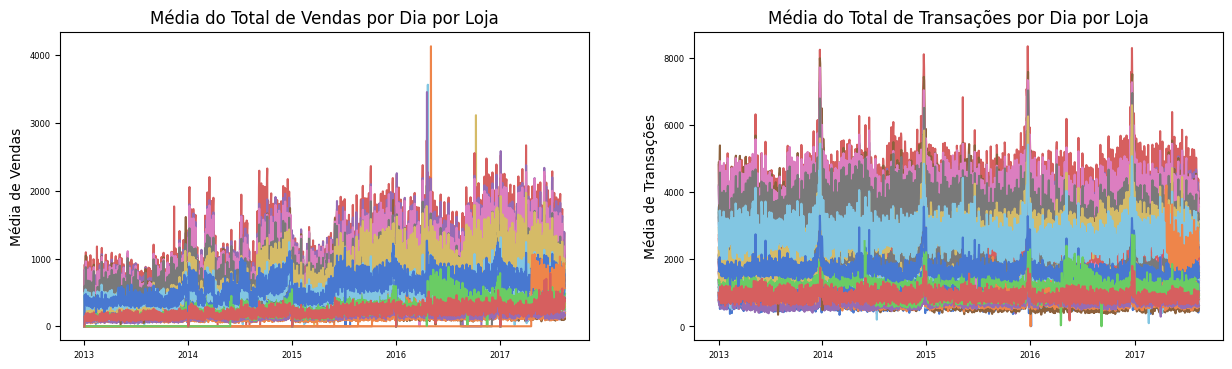

In [23]:
sales = df_train_eda.set_index("date").groupby("store_nbr").resample("D").sales.mean().reset_index()
transactions = df_transactions.set_index("date").groupby("store_nbr").resample("D").transactions.mean().reset_index()

fig, axes = plt.subplots(1,2 , figsize=(15, 4))

sns.lineplot(x=sales['date'], y=sales['sales'], ax=axes[0], hue=sales['store_nbr'], palette='muted')
axes[0].set_title('Média do Total de Vendas por Dia por Loja')
axes[0].set_ylabel('Média de Vendas')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', labelsize=6)
axes[0].tick_params(axis='y', labelsize=6)
axes[0].get_legend().remove()

sns.lineplot(x=transactions['date'], y=transactions['transactions'], ax=axes[1], hue=transactions['store_nbr'], palette='muted')
axes[1].set_title('Média do Total de Transações por Dia por Loja')
axes[1].set_ylabel('Média de Transações')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', labelsize=6)
axes[1].tick_params(axis='y', labelsize=6)
axes[1].get_legend().remove()

plt.show()

- Vemos claramente o aumento das transações no final do ano.

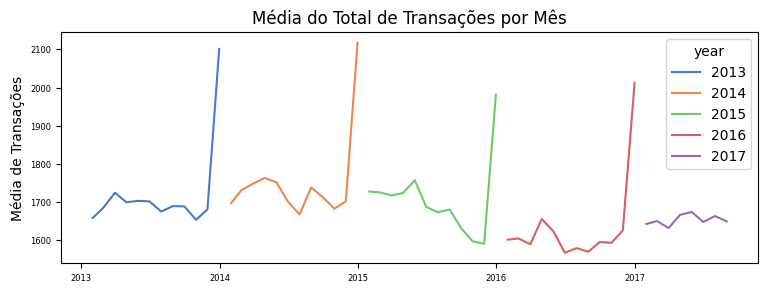

In [36]:
transactions = df_transactions.set_index("date").resample("ME").transactions.mean().reset_index()
transactions['year'] = transactions.date.dt.year
fig, axes = plt.subplots(figsize=(9, 3))

sns.lineplot(x=transactions['date'], y=transactions['transactions'], ax=axes, hue=transactions['year'], palette='muted')
axes.set_title('Média do Total de Transações por Mês')
axes.set_ylabel('Média de Transações')
axes.set_xlabel('')
axes.tick_params(axis='x', labelsize=6)
axes.tick_params(axis='y', labelsize=6)
#axes.get_legend().remove()


In [ ]:
store_sales = df_train_eda[['store_nbr', 'family', 'date', 'sales']]
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = store_sales.groupby('date').mean().squeeze()

- Podemos ver que existe uma grande concentração de vendas zeradas.

/home/yama/Projects/.virtualenvs/bmt/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


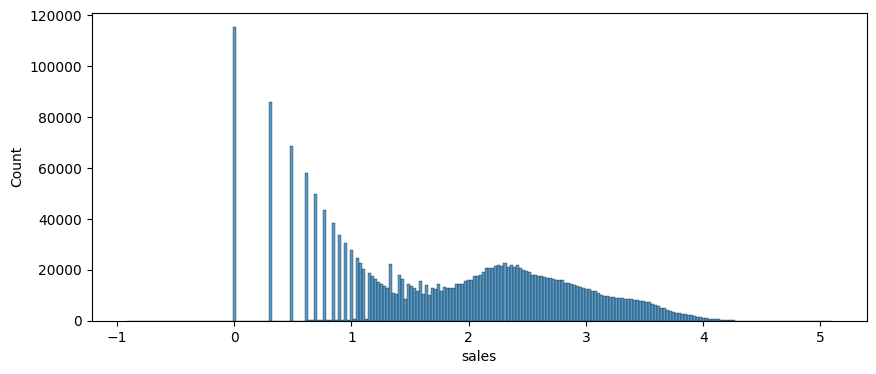

In [64]:
fig, axes = plt.subplots(figsize=(10, 4))

sns.histplot(x=np.log10(df_train['sales']), ax=axes)
plt.show()

- Neste gráfico podemos analisar a existência da sazonalidade nas vendas.
- Vemos que provavelmente existe uma sazonalidade semanal e anual nas vendas.

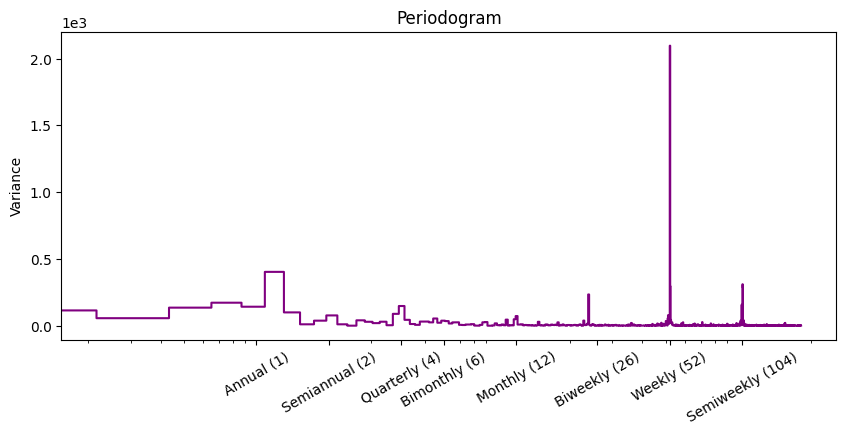

In [6]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

fig, ax = plt.subplots(figsize=(10, 4))
plot_periodogram(average_sales, ax=ax)
plt.show()

- Podemos ver que as vendas tendem a aumentar no final de semana.

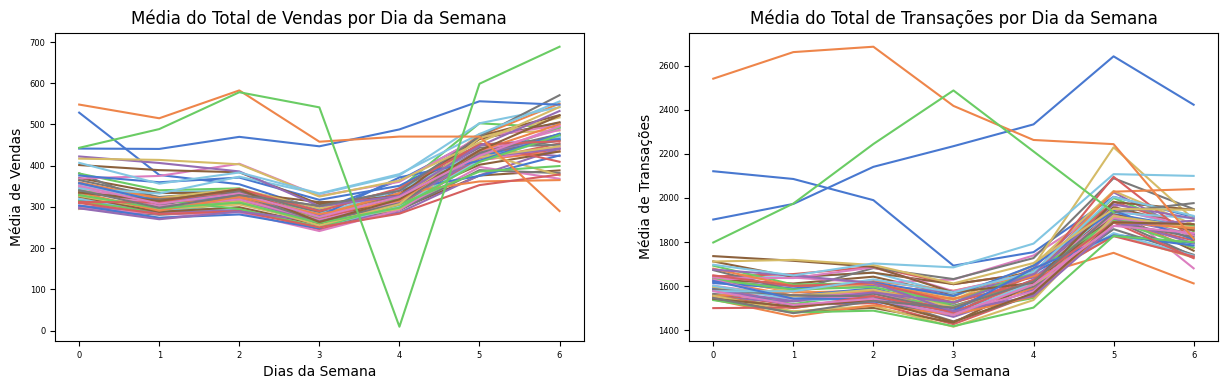

In [46]:
sales = df_train_eda.copy()
sales["week"] = sales.date.dt.isocalendar().week 
sales["day"] = sales.date.dt.dayofweek
sales = sales.groupby(['week', 'day']).sales.mean().reset_index()

transactions = df_transactions.copy()
transactions["week"] = transactions.date.dt.isocalendar().week 
transactions["day"] = transactions.date.dt.dayofweek
transactions = transactions.groupby(['week', 'day']).transactions.mean().reset_index()

fig, axes = plt.subplots(1,2 , figsize=(15, 4))

sns.lineplot(x=sales['day'], y=sales['sales'], ax=axes[0], hue=sales['week'], palette='muted')
axes[0].set_title('Média do Total de Vendas por Dia da Semana')
axes[0].set_ylabel('Média de Vendas')
axes[0].set_xlabel('Dias da Semana')
axes[0].tick_params(axis='x', labelsize=6)
axes[0].tick_params(axis='y', labelsize=6)
axes[0].get_legend().remove()

sns.lineplot(x=transactions['day'], y=transactions['transactions'], ax=axes[1], hue=transactions['week'], palette='muted')
axes[1].set_title('Média do Total de Transações por Dia da Semana')
axes[1].set_ylabel('Média de Transações')
axes[1].set_xlabel('Dias da Semana')
axes[1].tick_params(axis='x', labelsize=6)
axes[1].tick_params(axis='y', labelsize=6)
axes[1].get_legend().remove()

plt.show()

- Podemos analisar também a autocorrelação das vendas em relação à vendas em dias anteriores.
- Podemo perceber uma autocorrelação com as vendas ocorrendo semanalmente aqui também.

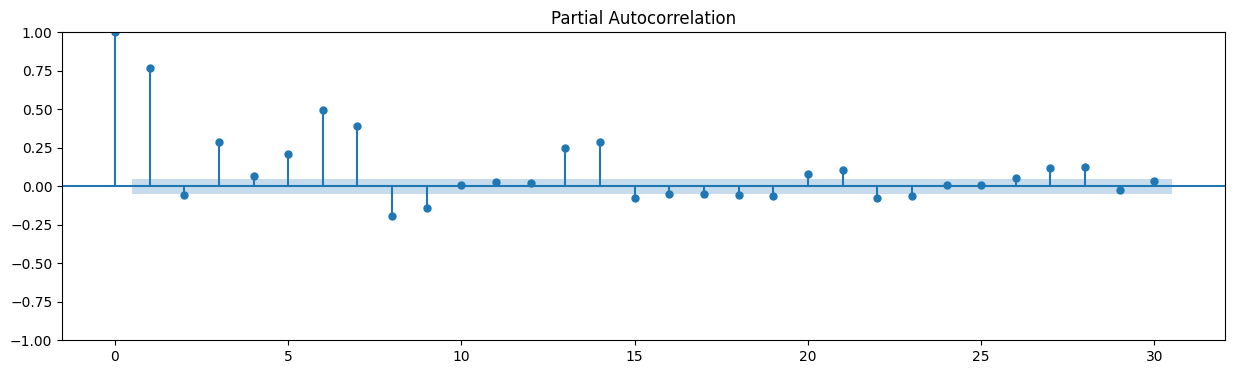

In [70]:
fig, axes = plt.subplots(figsize=(15, 4))
plot_pacf(average_sales, lags=30, ax=axes);

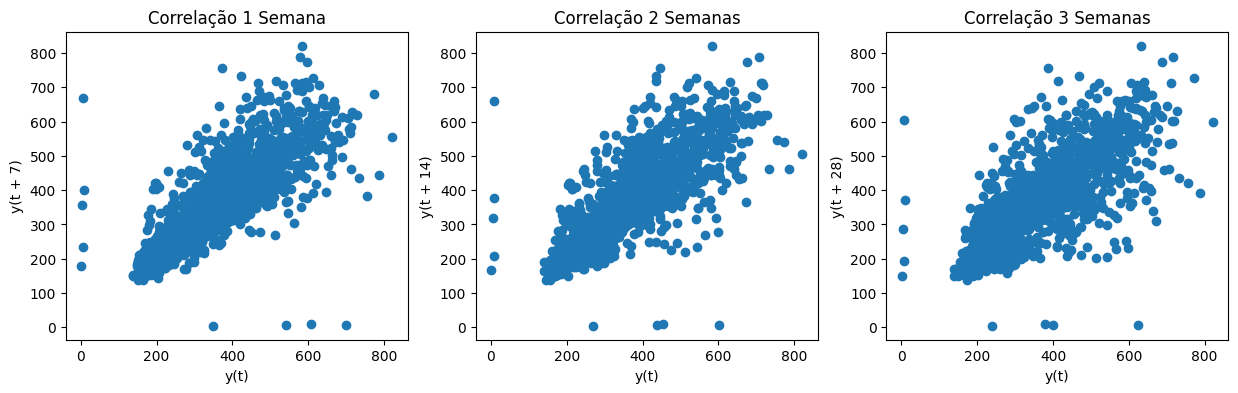

In [93]:
fig, axes = plt.subplots(1,3 , figsize=(15, 4))

lag_plot(average_sales, lag=7, ax=axes[0])
lag_plot(average_sales, lag=14, ax=axes[1])
lag_plot(average_sales, lag=28, ax=axes[2])

axes[0].set_title('Correlação 1 Semana')
axes[1].set_title('Correlação 2 Semanas')
axes[2].set_title('Correlação 3 Semanas')
plt.show()

### Preço petróleo

In [23]:
df_oil_eda = df_oil.set_index('date').dcoilwtico.resample("D").sum().reset_index()
df_oil_eda['dcoilwtico'] = np.where(df_oil_eda['dcoilwtico'] == 0, np.nan, df_oil_eda['dcoilwtico'])
df_oil_eda['dcoilwtico'] =df_oil_eda.dcoilwtico.interpolate()

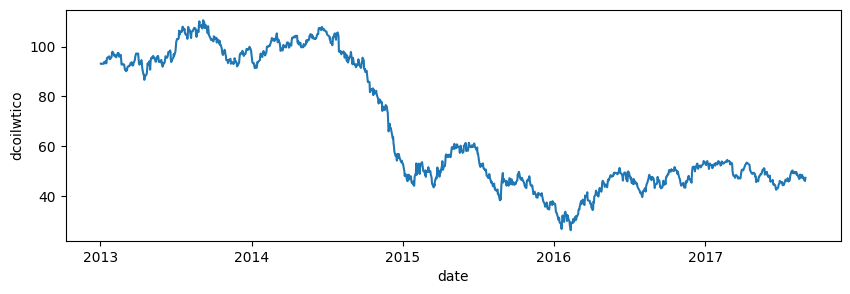

In [24]:
fig, axes = plt.subplots(figsize=(10, 3))
sns.lineplot(x=df_oil_eda['date'], y=df_oil_eda['dcoilwtico'], ax=axes)
plt.show()

- Aqui podemos perceber também uma correlação linear considerável entre o preço do petróleo e a venda diária média. 

In [47]:
mean_sales = df_train_eda.set_index("date").resample("D").sales.mean().reset_index()[['sales']]
mean_sales.corrwith(df_oil_eda[df_oil_eda['date'] <= '2017-08-15']['dcoilwtico'])

sales   -0.627968
dtype: float64

### Holidays

In [58]:
df_holidays_events.head(10)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [56]:
df_holidays_events['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [57]:
df_holidays_events['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

## Feature Engineering

Na costrução das features para o modelo foram testadas as seguintes configurações:

- Remoção de parte dos dados a partir de uma data de corte.
- Remoção dos dados associados ao final de ano. Isso só seria interessante para a competição no kaggle, em que os dados de teste não estão próximos do final do ano.
- Adição de variáveis relacionadas ao tempo. Ex: dia da semana, do mês e do ano, indicação de começo e fim de mês e ano, indicação do mês, etc. Como vimos que existe uma sazonalidade em diversos períodos de tempo, espera-se que com estes atributos temporais o modelo consiga capturar estes padrões.
- Para as informações de feriados foi utilizada uma ideia encontrada no forúm de discussão da competição. A ideia é agrupar os feriados nas seguintes categorias: national_holiday, earthquake_relief, christmas, football_event e national_event.
- Também foi adicionado as vendas de 3, 4 e 5 semanas anteriores o e número de transações de 3 semanas anteriores. Os dados começam com 3 semanas anteriores pois o modelo deve prever 15 dias no futuro, desta forma é possível utilzar os dados das semanas anteriores nos dados de teste.
- Foi adicionado os dados do preço do petróleo de 3 semanas anteriores.
- Por fim, foi testado também a utilização dos dados específicos de cada loja, como o cluster e tipo associados a ela. 

In [9]:
class DataPipeline:

    def __init__(self, data_preprocessors):
        self.data_preprocessors = data_preprocessors
        
    def transform(self, data, is_test=False):
        for preprocessor, kws in self.data_preprocessors:
            data = preprocessor(data, is_test=is_test, **kws)
        return data


class DataPreprocessor:

    def __init__(self):
        self.label_encoder = None
        self.train_data = None
        self.week_mean_df = None

    def base_setup(self, df, label_encoder, is_test=False):
        columns = ['date', 'store_nbr', 'family', 'sales', 'onpromotion']
        df = df.loc[:, columns]
        if is_test:
            df['family'] = self.label_encoder.transform(df['family'])
        else:
            self.label_encoder = label_encoder
            df['family'] = self.label_encoder.fit_transform(df['family'])
        return df
    
    def base_setup_sub2(self, df, label_encoder, is_test=False):

        if is_test:
            columns = ['date', 'store_nbr', 'family', 'onpromotion']
            df = df.loc[:, columns]
            df['family'] = self.label_encoder.transform(df['family'])
        else:
            self.label_encoder = label_encoder
            columns = ['date', 'store_nbr', 'family', 'onpromotion', 'sales']
            df = df.loc[:, columns]
            df['family'] = self.label_encoder.fit_transform(df['family'])

        return df
    
    def base_setup_sub(self, df, is_test=False):

        if is_test == True:
            columns = ['date', 'store_nbr', 'family', 'onpromotion']
        else:
            columns = ['date', 'store_nbr', 'family', 'sales', 'onpromotion']
            
        df = df.loc[:, columns]
        return df
    
    def base_setup2(self, df, is_test=False):
        columns = ['date', 'store_nbr', 'family', 'sales', 'onpromotion']
        df = df.loc[:, columns]
        return df
    
    def to_categorical(self, df, is_test=False):
        df['store_nbr'] = df['store_nbr'].astype('category') 
        df['family'] = df['family'].astype('category') 
        return df

    def start_date(self, df, cutoff_date, is_test=False):
        df = df[df['date'] >= cutoff_date]
        return df
    
    def remove_outliers(self, df, is_test=False):
        if is_test == False:
            mask = ~((df['date'].dt.month == 12) & (df['date'].dt.day >= 12) | 
            (df['date'].dt.month == 1) & (df['date'].dt.day <= 5))
            df = df[mask]

        return df

    def add_time_features(self, df, is_test=False):
        df = self._add_time_features(df)
        return df
    
    
    def add_holidays(self, df, is_test=False):

        dfh = pd.DataFrame(columns=['date'])
        dfh["date"] = df_holidays_events["date"]            
        dfh["national_holiday"] = np.where(((df_holidays_events["type"] == "Holiday") & (df_holidays_events["locale"] == "National")), 1, 0)
        dfh["earthquake_relief"] = np.where(df_holidays_events['description'].str.contains('Terremoto Manabi'), 1, 0)
        dfh["christmas"] = np.where(df_holidays_events['description'].str.contains('Navidad'), 1, 0)
        dfh["football_event"] = np.where(df_holidays_events['description'].str.contains('futbol'), 1, 0)
        national_event_condition = ((df_holidays_events["type"] == "Event") & (df_holidays_events["locale"] == "National") & (~df_holidays_events['description'].str.contains('Terremoto Manabi')) & (~df_holidays_events['description'].str.contains('futbol')))
        dfh["national_event"] = np.where(national_event_condition, 1, 0)
        dfh["work_day"] = np.where((df_holidays_events["type"] == "Work Day"), 1, 0)

        df = pd.merge(df, dfh, on=['date'], how='left')
        df = df.fillna(0.0)
        return df
    
    def add_lag_sales(self, df, is_test=False, lag_days_list=[21, 28, 35]):

        if is_test == False:
            self.train_data = df

        for days in lag_days_list:
            if is_test:
                full_df = pd.concat([self.train_data, df], axis=0).reset_index()
                df_shifted = self._shift_sales(full_df, days)
                df = df.merge(df_shifted[['store_nbr', 'family', 'date', f'sales_{days}_days_ago']], on=['store_nbr', 'family', 'date'], how='left')
                cutoff_date = df.iloc[0]['date'] + pd.Timedelta(days=days)
                df.loc[df['date'] >= cutoff_date, f'sales_{days}_days_ago'] = np.nan
            else:
                df = self._shift_sales(df, days)
                df[f'sales_{days}_days_ago'] = df[f'sales_{days}_days_ago'].ffill(limit=days)

        return df
    
    def add_lag_transactions(self, df, df_transactions, is_test=False, lag_days_list=[21, 28, 35]):

        for days in lag_days_list:
            if is_test:
                df_shifted = self._shift_transactions(df, df_transactions, days)
                df = df_shifted
            else:
                df = self._shift_transactions(df, df_transactions, days)
                df[f'transactions_{days}_days_ago'] = df[f'transactions_{days}_days_ago'].ffill(limit=days)

        return df
    
    def add_lag_oil(self, df, df_oil, is_test=False, lag_days_list=[21, 28, 35]):

        for days in lag_days_list:
            if is_test:
                df_shifted = self._shift_oil(df, df_oil, days)
                df = df_shifted
            else:
                df = self._shift_oil(df, df_oil, days)
                df[f'oil_{days}_days_ago'] = df[f'oil_{days}_days_ago'].ffill(limit=days)

        return df
    
    def add_stores_info(self, df, df_stores, is_test=False):

        df = df.merge(df_stores.loc[:, ['store_nbr','type', 'cluster']], on=['store_nbr'], how='left')
        df['type'] = df['type'].astype('category') 
        df['cluster'] = df['cluster'].astype('category') 
        return df 


    def _shift_sales(self, df, days):
        df_copy = df.copy()
        df_copy['date'] += pd.Timedelta(days=days)
        df_copy.rename(columns={'sales': f'sales_{days}_days_ago'}, inplace=True)
        return df.merge(df_copy[['store_nbr', 'family', 'date', f'sales_{days}_days_ago']], on=['store_nbr', 'family', 'date'], how='left')
    
    def _shift_transactions(self, df, df_transactions, days):
        df_copy = df_transactions.copy()
        df_copy['date'] += pd.Timedelta(days=days)
        df_copy.rename(columns={'transactions': f'transactions_{days}_days_ago'}, inplace=True)
        return df.merge(df_copy[['store_nbr', 'date', f'transactions_{days}_days_ago']], on=['store_nbr', 'date'], how='left')
    
    def _shift_oil(self, df, df_oil, days):
        df_copy = df_oil.copy()
        df_copy['date'] += pd.Timedelta(days=days)
        df_copy.rename(columns={'dcoilwtico': f'oil_{days}_days_ago'}, inplace=True)
        return df.merge(df_copy[['date', f'oil_{days}_days_ago']], on=['date'], how='left')


    def _add_time_features(self, df):
        df['year'] = df.date.dt.year.astype("int32")
        df['month'] = df.date.dt.month.astype("int8")
        df['day_of_year'] = df.date.dt.dayofyear.astype("int16")
        df['day_of_month'] = df.date.dt.day.astype("int8")
        df['day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
        df['weekend'] = (df.date.dt.weekday // 4).astype("int8")
        df['quarter'] = df.date.dt.quarter.astype("int8")
        df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
        df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
        df['is_quarter_start'] = df.date.dt.is_quarter_start.astype("int8")
        df['is_quarter_end'] = df.date.dt.is_quarter_end.astype("int8")
        df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
        df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
        return df

In [35]:
df_oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


## Modelo

- Cada configuração de atributos e modelos foi validada com um esquema de cross-validation utilizando 5 partições. Cada partição de teste corresponde a 15 dias, começando com os 15 últimos dias do dataset e cada partição de teste seguinte é formada pelos 15 dias anteriores consecutivamente.

In [6]:
class TimeSplit:

    def __init__(self, test_days, splits=5):
        self.test_days = pd.Timedelta(days=test_days)
        self.splits = splits

    def split(self, data):
        
        last_date_train = data.iloc[-1]['date'] - self.test_days
        last_date_test = last_date_train + self.test_days


        for _ in range(self.splits):
            
            yield last_date_train, last_date_test

            last_date_test = last_date_train
            last_date_train = last_date_train - self.test_days

def crossval(data, data_pipeline, model_params={}, test_size_days=15, **kwargs):
    
    ts = TimeSplit(test_days=test_size_days)

    rmsle_list = []
    datasets = []

    for i, (last_date_train, last_date_test) in enumerate(ts.split(data)):
        
        data_train = data[data['date'] <= last_date_train]
        data_test = data[((data['date'] > last_date_train) & (data['date'] <= last_date_test))]

        data_train = data_pipeline.transform(data_train)
        data_test = data_pipeline.transform(data_test, is_test=True)
        
        X_train, y_train = data_train.drop(['sales', 'date'], axis=1), data_train.loc[:, 'sales']
        X_test, y_test = data_test.drop(['sales', 'date'], axis=1), data_test.loc[:, 'sales']

        datasets.append((X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy()))
        
        lgb_train_data = lgb.Dataset(X_train, label=y_train)
        lgb_test_data = lgb.Dataset(X_test, label=y_test, reference=lgb_train_data)

        num_round = 1000
        callbacks = [early_stopping(stopping_rounds=50)]

        model = lgb.train(model_params, lgb_train_data, num_round, valid_sets=[lgb_test_data],callbacks = callbacks)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_pred[y_pred <= 0] = 0

        rmsle = root_mean_squared_log_error(y_test, y_pred)
        rmsle_list.append(rmsle)

        print(f'*********** {i+1} ************')
        print(f'RMSLE: {rmsle}')

    print('*********** AVG ************')
    print(f'RMSLE: {np.mean(rmsle_list)}')

    return {'rmsle_avg': np.mean(rmsle_list),
            'rmsle_list': rmsle_list,
            'data_train': data_train,
            'data_test': data_test,
            'model': model}

- Como baseline foi testado um modelo de gradient boosting (LightGBM) com todos os hiperparâmetros padrão e uma configuração somente com os atributos temporais. Foi escolhido um modelo baseado em árvores pois facilita a preparação dos dados, aceitando dados em diferentes escalas e tipos categóricos.

In [9]:
dp = DataPreprocessor()
preprocessors_funcs = [ (dp.base_setup, {'label_encoder': LabelEncoder()}),
                        (dp.add_time_features, {}),
                        (dp.to_categorical, {})]
data_pipeline = DataPipeline(preprocessors_funcs)
results = crossval(data = df_train,
                   model_params={'verbose':-1, 'seed': 42},
                   data_pipeline=data_pipeline)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[869]	valid_0's l2: 55611.8
*********** 1 ************
RMSLE: 0.82795441464769
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[984]	valid_0's l2: 43204.4
*********** 2 ************
RMSLE: 0.8315221757476021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[762]	valid_0's l2: 44875.3
*********** 3 ************
RMSLE: 0.8249037265292721
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[165]	valid_0's l2: 63707.6
*********** 4 ************
RMSLE: 0.9371219834811831
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[893]	valid_0's l2: 82350.4
*********** 5 ************
RMSLE: 0.8254641420390083
*********** AVG ************
RMSLE: 0.849393288488951


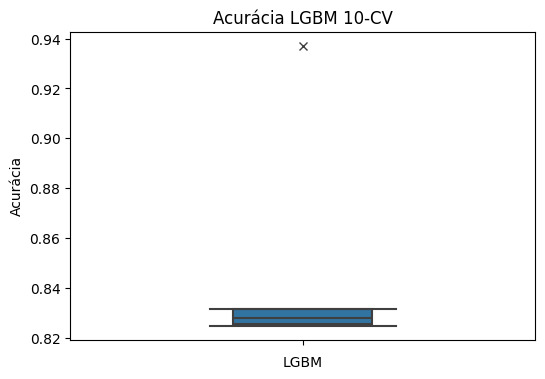

In [8]:
fig, axes = plt.subplots(figsize=(6, 4))
sns.boxplot(y=results['rmsle_list'],  linewidth=1.5, widths=.3, flierprops={"marker": "x"}, ax=axes)
axes.set_ylabel('RMSLE')
axes.set_xlabel('LGBM')
axes.set_title('RMSLE LGBM 5-CV')
plt.show()

- Como a distribuição das vendas possui muitos valores zerados (parecido com uma distribuição Tweedie), foi testado um modelo considerando esta distribuição. 
- Vemos que com esta mudança os modelos apresentaram melhoras significativas.

In [10]:
results_configs = []

- Somente time features.

In [11]:
dp = DataPreprocessor()
preprocessors_funcs = [ (dp.base_setup, {'label_encoder': LabelEncoder()}),
                        (dp.add_time_features, {}),
                        (dp.to_categorical, {})]
data_pipeline = DataPipeline(preprocessors_funcs)
results = crossval(data = df_train,
                   model_params={'verbose':-1, 'seed': 42, 'objective': 'tweedie'},
                   data_pipeline=data_pipeline)

results_configs.append(results)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[660]	valid_0's tweedie: 51.9146
*********** 1 ************
RMSLE: 0.4266712234140121
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's tweedie: 51.7132
*********** 2 ************
RMSLE: 0.42585979511459326
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[964]	valid_0's tweedie: 52.8604
*********** 3 ************
RMSLE: 0.4028600876477095
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's tweedie: 51.8455
*********** 4 ************
RMSLE: 0.4164817772316292
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's tweedie: 52.9613
*********** 5 ************
RMSLE: 0.4197971939975095
*********** AVG ************
RMSLE:

- Remoção dos dados de fim de ano.

In [12]:
dp = DataPreprocessor()
preprocessors_funcs = [ (dp.base_setup, {'label_encoder': LabelEncoder()}),
                        (dp.add_time_features, {}),
                        (dp.remove_outliers, {}),
                        (dp.to_categorical, {})]
data_pipeline = DataPipeline(preprocessors_funcs)
results = crossval(data = df_train,
                   model_params={'verbose':-1, 'seed': 42, 'objective': 'tweedie'},
                   data_pipeline=data_pipeline)

results_configs.append(results)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[818]	valid_0's tweedie: 51.9058
*********** 1 ************
RMSLE: 0.42430265750221263
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's tweedie: 51.7059
*********** 2 ************
RMSLE: 0.4218899626681584
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[845]	valid_0's tweedie: 52.8563
*********** 3 ************
RMSLE: 0.4035685322403696
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's tweedie: 51.8421
*********** 4 ************
RMSLE: 0.4163233798863191
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's tweedie: 52.9788
*********** 5 ************
RMSLE: 0.42072104655175785
*********** AVG ************
RMSLE: 0.4173611157

- Adição dos feriados.

In [13]:
dp = DataPreprocessor()
preprocessors_funcs = [ (dp.base_setup, {'label_encoder': LabelEncoder()}),
                        (dp.add_time_features, {}),
                        (dp.remove_outliers, {}),
                        (dp.add_holidays, {}),
                        (dp.to_categorical, {})]
data_pipeline = DataPipeline(preprocessors_funcs)
results = crossval(data = df_train,
                   model_params={'verbose':-1, 'seed': 42, 'objective': 'tweedie'},
                   data_pipeline=data_pipeline)

results_configs.append(results)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's tweedie: 51.8825
*********** 1 ************
RMSLE: 0.41913438675054304
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[900]	valid_0's tweedie: 51.7129
*********** 2 ************
RMSLE: 0.42328105090969925
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[961]	valid_0's tweedie: 52.9268
*********** 3 ************
RMSLE: 0.39948723910960365
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's tweedie: 52.5939
*********** 4 ************
RMSLE: 0.41196536424641733
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's tweedie: 52.9515
*********** 5 ************
RMSLE: 0.4164430138234893
*********** AVG ************
RMSL

- Adição das vendas e transações anteriores.

In [14]:
dp = DataPreprocessor()
preprocessors_funcs = [ (dp.base_setup, {'label_encoder': LabelEncoder()}),
                        (dp.add_time_features, {}),
                        (dp.remove_outliers, {}),
                        (dp.add_holidays, {}),
                        (dp.add_lag_sales, {'lag_days_list': [21, 28, 35]}),
                        (dp.add_lag_transactions, {'df_transactions': df_transactions, 'lag_days_list':[21]}),
                        (dp.to_categorical, {})]
data_pipeline = DataPipeline(preprocessors_funcs)
results = crossval(data = df_train,
                   model_params={'verbose':-1, 'seed': 42, 'objective': 'tweedie'},
                   data_pipeline=data_pipeline)

results_configs.append(results)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's tweedie: 51.8559
*********** 1 ************
RMSLE: 0.43389954175005396
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[622]	valid_0's tweedie: 53.0448
*********** 2 ************
RMSLE: 0.4265881805115914
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's tweedie: 55.0042
*********** 3 ************
RMSLE: 0.397608330115683
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[820]	valid_0's tweedie: 58.1983
*********** 4 ************
RMSLE: 0.3809883418696614
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's tweedie: 52.9027
*********** 5 ************
RMSLE: 0.4274285372433802
*********** AVG ************
RMSLE: 0.41330258629807404


- Adição do preço do petróleo.

In [15]:
dp = DataPreprocessor()
preprocessors_funcs = [ (dp.base_setup, {'label_encoder': LabelEncoder()}),
                        (dp.add_time_features, {}),
                        (dp.remove_outliers, {}),
                        (dp.add_holidays, {}),
                        (dp.add_lag_sales, {'lag_days_list': [21, 28, 35]}),
                        (dp.add_lag_transactions, {'df_transactions': df_transactions, 'lag_days_list':[21]}),
                        (dp.add_lag_oil, {'df_oil': df_oil, 'lag_days_list':[21]}),
                        (dp.to_categorical, {})]
data_pipeline = DataPipeline(preprocessors_funcs)
results = crossval(data = df_train,
                   model_params={'verbose':-1, 'seed': 42, 'objective': 'tweedie'},
                   data_pipeline=data_pipeline)

results_configs.append(results)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[873]	valid_0's tweedie: 51.7993
*********** 1 ************
RMSLE: 0.42096583701121015
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[882]	valid_0's tweedie: 53.0068
*********** 2 ************
RMSLE: 0.42101518170401603
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's tweedie: 55.009
*********** 3 ************
RMSLE: 0.39421566997410684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[664]	valid_0's tweedie: 58.1955
*********** 4 ************
RMSLE: 0.37853961299869815
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's tweedie: 52.9006
*********** 5 ************
RMSLE: 0.42643994049389883
*********** AVG ************
RMSLE: 0.40823524843638603


- Comparação das configurações.

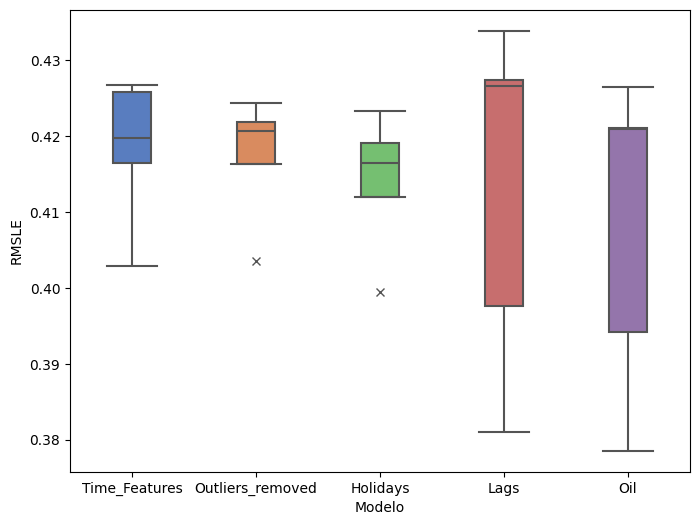

In [26]:
models = ['Time_Features', 'Outliers_removed', 'Holidays', 'Lags', 'Oil']

models_results_plot = {'Modelo': [], 'RMSLE': []}

for model_results, name in zip(results_configs, models):
    for result in model_results['rmsle_list']:
        models_results_plot['Modelo'].append(name)
        models_results_plot['RMSLE'].append(result)

models_results_df = pd.DataFrame(models_results_plot)

fig, axes = plt.subplots(figsize=(8, 6))

sns.boxplot(data=models_results_df, x='Modelo', y='RMSLE',  
              linewidth=1.5, widths=.3, palette='muted', hue='Modelo', flierprops={"marker": "x"},
              order=['Time_Features', 'Outliers_removed', 'Holidays', 'Lags', 'Oil'], ax=axes)
plt.show()

- Para definir os hiperparâmetros foi utilizada a biblioteca Optuna. O modelo foi otimizado para minimizar o RMSLE. Aqui foi utilizado para validação somente os últmios 15 dias do dataset de treinamento.
- Foram utilizadas as features que apresentaram os melhores resultado nos experimentos anteriores.

In [20]:
dp = DataPreprocessor()
preprocessors_funcs = [ (dp.base_setup, {'label_encoder': LabelEncoder()}),
                        (dp.add_time_features, {}),
                        (dp.remove_outliers, {}),
                        (dp.add_holidays, {}),
                        (dp.add_lag_sales, {'lag_days_list': [28, 35, 42]}),
                        (dp.add_lag_oil, {'df_oil': df_oil, 'lag_days_list':[21]}),
                        (dp.add_lag_transactions, {'df_transactions': df_transactions, 'lag_days_list':[21]}),
                        (dp.to_categorical, {})]
data_pipeline = DataPipeline(preprocessors_funcs)

data_train = df_train[df_train['date'] < '2017-08-01']
data_test = df_train[df_train['date'] >= '2017-08-01']

data_train = data_pipeline.transform(data_train)
data_test = data_pipeline.transform(data_test, is_test=True)
        
X_train, y_train = data_train.drop(['sales', 'date'], axis=1), data_train.loc[:, 'sales']
X_test, y_test = data_test.drop(['sales', 'date'], axis=1), data_test.loc[:, 'sales']

- Features Utilizadas

In [21]:
data_train.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year', 'month',
       'day_of_year', 'day_of_month', 'day_of_week', 'weekend', 'quarter',
       'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end',
       'is_year_start', 'is_year_end', 'national_holiday', 'earthquake_relief',
       'christmas', 'football_event', 'national_event', 'work_day',
       'sales_28_days_ago', 'sales_35_days_ago', 'sales_42_days_ago',
       'oil_21_days_ago', 'transactions_21_days_ago'],
      dtype='object')

- Definição do hiperparâmetros com o Optuna.

In [ ]:
def objective(trial):

    params = {
        "objective": "tweedie",
        "metric": "rmse",
        "n_estimators": 1000,
        "verbose": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1024),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    lgb_train_data = lgb.Dataset(X_train, label=y_train)
    lgb_test_data = lgb.Dataset(X_test, label=y_test, reference=lgb_train_data)

    num_round = 1000
    callbacks = [early_stopping(stopping_rounds=50)]

    model = lgb.train(params, lgb_train_data, num_round, valid_sets=[lgb_test_data],callbacks = callbacks)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred[y_pred <= 0] = 0

    rmsle = root_mean_squared_log_error(y_test, y_pred)

    return rmsle

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=23)
print('Best hyperparameters:', study.best_params)
print('Best RMSLE:', study.best_value)

#Best hyperparameters: {'learning_rate': 0.06327435568658898, 'num_leaves': 766, 'subsample': 0.7905485609236188, 'colsample_bytree': 0.6538403282278586, 'min_data_in_leaf': 45}
#Best RMSLE: 0.4055237580526578

- Resultado do modelo treinado com os hiperparâmetros definidos pelo Optuna e validado utilizando o esquema de validação cruzada.

In [23]:
import warnings
warnings.filterwarnings('ignore')
dp = DataPreprocessor()
preprocessors_funcs = [ (dp.base_setup, {'label_encoder': LabelEncoder()}),
                        (dp.add_time_features, {}),
                        (dp.remove_outliers, {}),
                        (dp.add_holidays, {}),
                        (dp.add_lag_sales, {'lag_days_list': [21, 28, 35]}),
                        (dp.add_lag_transactions, {'df_transactions': df_transactions, 'lag_days_list':[21]}),
                        (dp.add_lag_oil, {'df_oil': df_oil, 'lag_days_list':[21]}),
                        (dp.to_categorical, {})]
data_pipeline = DataPipeline(preprocessors_funcs)
results = crossval(data = df_train,
                   model_params={'verbose':-1, 'seed': 42, 'objective': 'tweedie',
                                 "metric": "rmse", "n_estimators": 1000, "bagging_freq": 1,
                                 'learning_rate': 0.06327435568658898, 'num_leaves': 766, 'subsample': 0.7905485609236188,
                                 'colsample_bytree': 0.6538403282278586, 'min_data_in_leaf': 45},
                   data_pipeline=data_pipeline)

results_configs.append(results)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[855]	valid_0's rmse: 191.907
*********** 1 ************
RMSLE: 0.4036410991641209
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[176]	valid_0's rmse: 206.495
*********** 2 ************
RMSLE: 0.41981354865437087
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	valid_0's rmse: 197.654
*********** 3 ************
RMSLE: 0.4018561448228811
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	valid_0's rmse: 379.556
*********** 4 ************
RMSLE: 0.38508843175203533
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[152]	valid_0's rmse: 276.928
*********** 5 ************
RMSLE: 0.42975696234667454
*********** AVG ************
RMSLE: 0.4080312373480165


- Foi testado também treinar um modelo individual para cada família de produto.
- Vemos que desta forma foram obtidos os melhores resultados.
- Esta configuração foi a escolhida para a submissão no desafio do Kaggle.

In [24]:
import warnings
warnings.filterwarnings('ignore')

dp = DataPreprocessor()
preprocessors_funcs = [ (dp.base_setup2, {}),
                        (dp.add_time_features, {}),
                        (dp.remove_outliers, {}),
                        (dp.add_holidays, {}),
                        (dp.add_lag_sales, {'lag_days_list': [21, 28, 35]}),
                        (dp.add_lag_transactions, {'df_transactions': df_transactions, 'lag_days_list':[21]}),
                        (dp.add_lag_oil, {'df_oil': df_oil, 'lag_days_list':[21]}),
                        (dp.to_categorical, {})]
data_pipeline = DataPipeline(preprocessors_funcs)

test_date = '2017-08-01'
cutoff_date = '2013-01-01'

data_train = df_train[((df_train['date'] >= cutoff_date ) & (df_train['date'] < test_date))]
data_test = df_train[df_train['date'] >= test_date]

data_train = data_pipeline.transform(data_train)
data_test = data_pipeline.transform(data_test, is_test=True)

family_list = data_train['family'].unique()
family_models = {}
rmsle_list = []

for family in family_list:
    
    data_train_f = data_train[data_train['family'] == family]
    data_test_f = data_test[data_test['family'] == family]
        
    X_train, y_train = data_train_f.drop(['sales', 'date', 'family'], axis=1), data_train_f.loc[:, 'sales']
    X_test, y_test = data_test_f.drop(['sales', 'date', 'family'], axis=1), data_test_f.loc[:, 'sales']


    params = {'boosting_type': 'gbdt','objective': 'tweedie','metric': 'rmse','learning_rate': 0.06327435568658898, 
              'num_leaves': 766, 'subsample': 0.7905485609236188, 'colsample_bytree': 0.6538403282278586, 
              'min_data_in_leaf': 45,'seed': 42,'verbose':-1}

    lgb_train_data = lgb.Dataset(X_train, label=y_train)
    lgb_test_data = lgb.Dataset(X_test, label=y_test, reference=lgb_train_data)

    num_round = 1000
    callbacks = [early_stopping(stopping_rounds=50)]

    model = lgb.train(params, lgb_train_data, num_round, valid_sets=[lgb_test_data],callbacks = callbacks)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred[y_pred <= 0] = 0

    rmsle = root_mean_squared_log_error(y_test, y_pred)
    rmsle_list.append(rmsle)
    family_models[family] = model

    print(f'*********** {family} ************')
    print(f'RMSLE: {rmsle}')

print('*********** AVG ************')
print(f'RMSLE: {np.mean(rmsle_list)}')

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 3.8283
*********** AUTOMOTIVE ************
RMSLE: 0.5217963434483315
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 0.542544
*********** BABY CARE ************
RMSLE: 0.27958115659334504
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	valid_0's rmse: 3.6355
*********** BEAUTY ************
RMSLE: 0.5011451170619442
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 799.183
*********** BEVERAGES ************
RMSLE: 0.22588588867122822
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 0.107466
*********** BOOKS ************
RMSLE: 0.06875154972892217
Training until validation scores don't improve for 50 rounds
Early stoppi

- Treinamento do modelo com todos os dados de treinamento

In [25]:
dp = DataPreprocessor()

preprocessors_funcs = [ (dp.base_setup_sub, {}),
                        (dp.add_time_features, {}),
                        (dp.remove_outliers, {}),
                        (dp.add_holidays, {}),
                        (dp.add_lag_sales, {'lag_days_list': [21, 28, 35]}),
                        (dp.add_lag_transactions, {'df_transactions': df_transactions, 'lag_days_list':[21]}),
                        (dp.add_lag_oil, {'df_oil': df_oil, 'lag_days_list':[21]}),
                        (dp.to_categorical, {})]
    
data_pipeline = DataPipeline(preprocessors_funcs)

test_date = '2017-08-01'
cutoff_date = '2013-01-01'

data_train = df_train[((df_train['date'] >= cutoff_date))]
data_test = df_test.copy()

data_train = data_pipeline.transform(data_train)
data_test = data_pipeline.transform(data_test, is_test=True)

family_list = data_train['family'].unique()
family_models = {}

for family in family_list:
    
    data_train_f = data_train[data_train['family'] == family]
        
    X_train, y_train = data_train_f.drop(['sales', 'date', 'family'], axis=1), data_train_f.loc[:, 'sales']

    params = {'boosting_type': 'gbdt','objective': 'tweedie','metric': 'rmse','learning_rate': 0.06327435568658898, 
              'num_leaves': 766, 'subsample': 0.7905485609236188, 'colsample_bytree': 0.6538403282278586, 
              'min_data_in_leaf': 45,'seed': 42,'verbose':-1}

    lgb_train_data = lgb.Dataset(X_train, label=y_train)

    num_round = 1000
    callbacks = [early_stopping(stopping_rounds=50)]

    model = lgb.train(params, lgb_train_data, num_round)
    family_models[family] = model

- Construção do arquivo de submissão no kaggle

In [26]:
df_resp = df_test.copy()
df_resp['sales'] = np.nan

for family in family_list:

    data_test_f = data_test[data_test['family'] == family]
    X_test = data_test_f.drop(['date', 'family'], axis=1)

    model = family_models[family]

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred[y_pred <= 0] = 0

    df_resp.loc[df_resp['family'] == family, 'sales'] = y_pred

In [27]:
test_output_dict = {'id': df_resp['id'], 'sales': df_resp['sales'].astype(np.float32)}
test_output = pd.DataFrame(test_output_dict)
test_output

,id,sales
0,3000888,4.407499e+00
1,3000889,2.826248e-13
2,3000890,5.864414e+00
3,3000891,2.373024e+03
4,3000892,4.108660e-08
...,...,...
28507,3029395,3.377856e+02
28508,3029396,9.588848e+01
28509,3029397,1.172508e+03
28510,3029398,1.016145e+02


In [28]:
test_output.to_csv('sub.csv', index=False)